In [2]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

# authenticate
credential = DefaultAzureCredential()

SUBSCRIPTION="c7c6789b-4563-4b2f-a727-cc937cf26877"
RESOURCE_GROUP="declan.bracken-rg"
WS_NAME="DeclansA5"

# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id=SUBSCRIPTION,
    resource_group_name=RESOURCE_GROUP,
    workspace_name=WS_NAME,
)

In [3]:
# Verify that the handle works correctly.  
# If you ge an error here, modify your SUBSCRIPTION, RESOURCE_GROUP, and WS_NAME in the previous cell.
ws = ml_client.workspaces.get(WS_NAME)
print(ws.location,":", ws.resource_group)

canadacentral : declan.bracken-rg


In [16]:
%pip install ucimlrepo

^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [4]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np

# fetch dataset 
parkinsons_telemonitoring = fetch_ucirepo(id=189) 
  
# data (as pandas dataframes) 
X = parkinsons_telemonitoring.data.features 
y = parkinsons_telemonitoring.data.targets 
  
# metadata 
print(parkinsons_telemonitoring.metadata) 

pd.set_option('display.max_colwidth', None)  # or use a large number instead of None for older pandas versions
print(parkinsons_telemonitoring.variables)



{'uci_id': 189, 'name': 'Parkinsons Telemonitoring', 'repository_url': 'https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring', 'data_url': 'https://archive.ics.uci.edu/static/public/189/data.csv', 'abstract': "Oxford Parkinson's Disease Telemonitoring Dataset", 'area': 'Health and Medicine', 'tasks': ['Regression'], 'characteristics': ['Tabular'], 'num_instances': 5875, 'num_features': 19, 'feature_types': ['Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['motor_UPDRS', 'total_UPDRS'], 'index_col': ['subject#'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5ZS3N', 'creators': ['Athanasios Tsanas', 'Max Little'], 'intro_paper': {'title': "Accurate Telemonitoring of Parkinson's Disease Progression by Noninvasive Speech Tests", 'authors': 'A. Tsanas, Max A. Little, P. McSharry, L. Ramig', 'published_in': 'IEEE Transactions on Biomedical Engineering', 

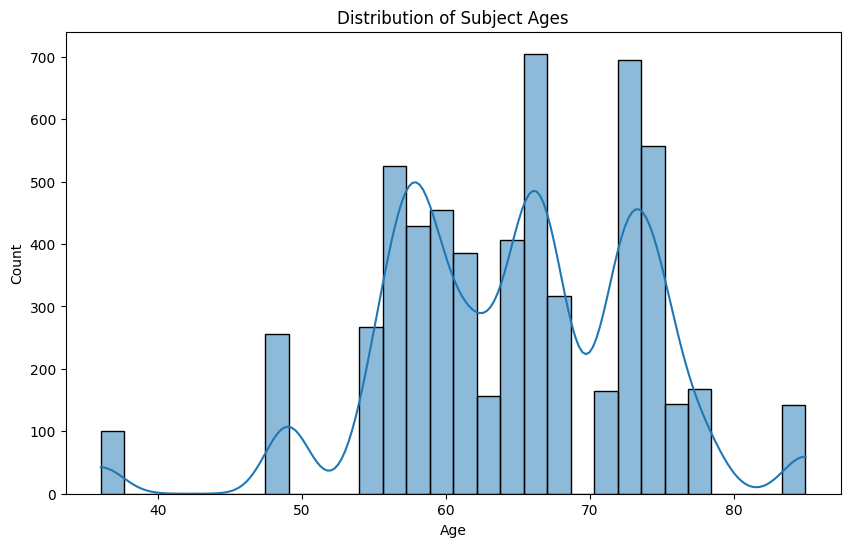

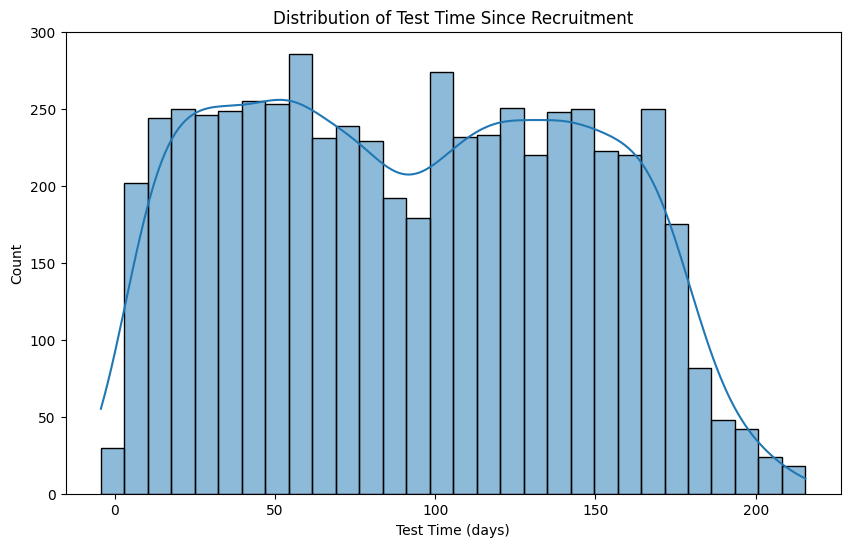

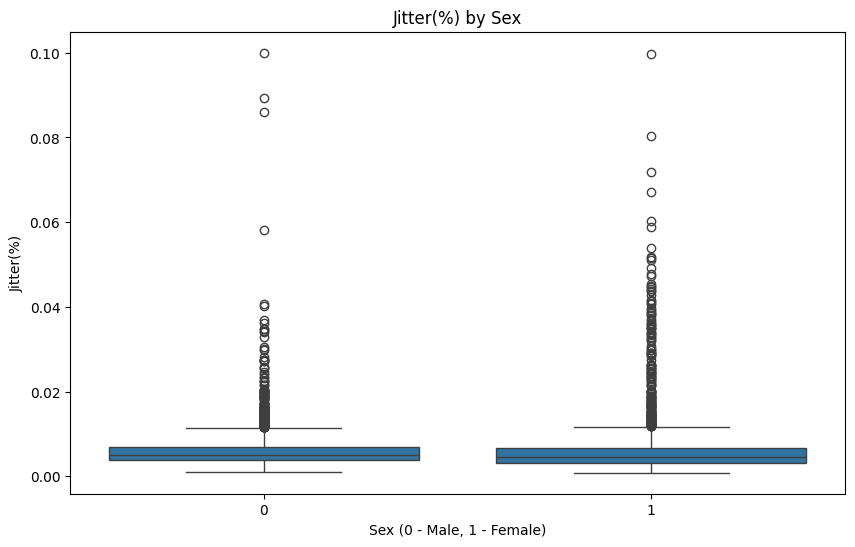

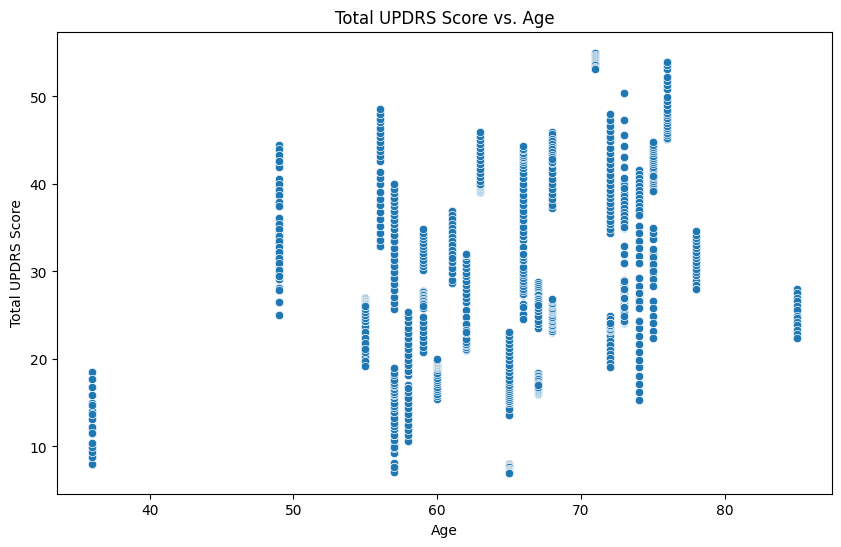

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.concat([X, y], axis = 1)

# Figure 1: Distribution of Age
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Distribution of Subject Ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Figure 2: Distribution of Test Time
plt.figure(figsize=(10, 6))
sns.histplot(df['test_time'], bins=30, kde=True)
plt.title('Distribution of Test Time Since Recruitment')
plt.xlabel('Test Time (days)')
plt.ylabel('Count')
plt.show()

# Figure 3: Boxplot of Jitter(%) by Sex
plt.figure(figsize=(10, 6))
sns.boxplot(x='sex', y='Jitter(%)', data=df)
plt.title('Jitter(%) by Sex')
plt.xlabel('Sex (0 - Male, 1 - Female)')
plt.ylabel('Jitter(%)')
plt.show()

# Figure 4: Scatter plot of Total UPDRS vs. Age
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='total_UPDRS', data=df)
plt.title('Total UPDRS Score vs. Age')
plt.xlabel('Age')
plt.ylabel('Total UPDRS Score')
plt.show()


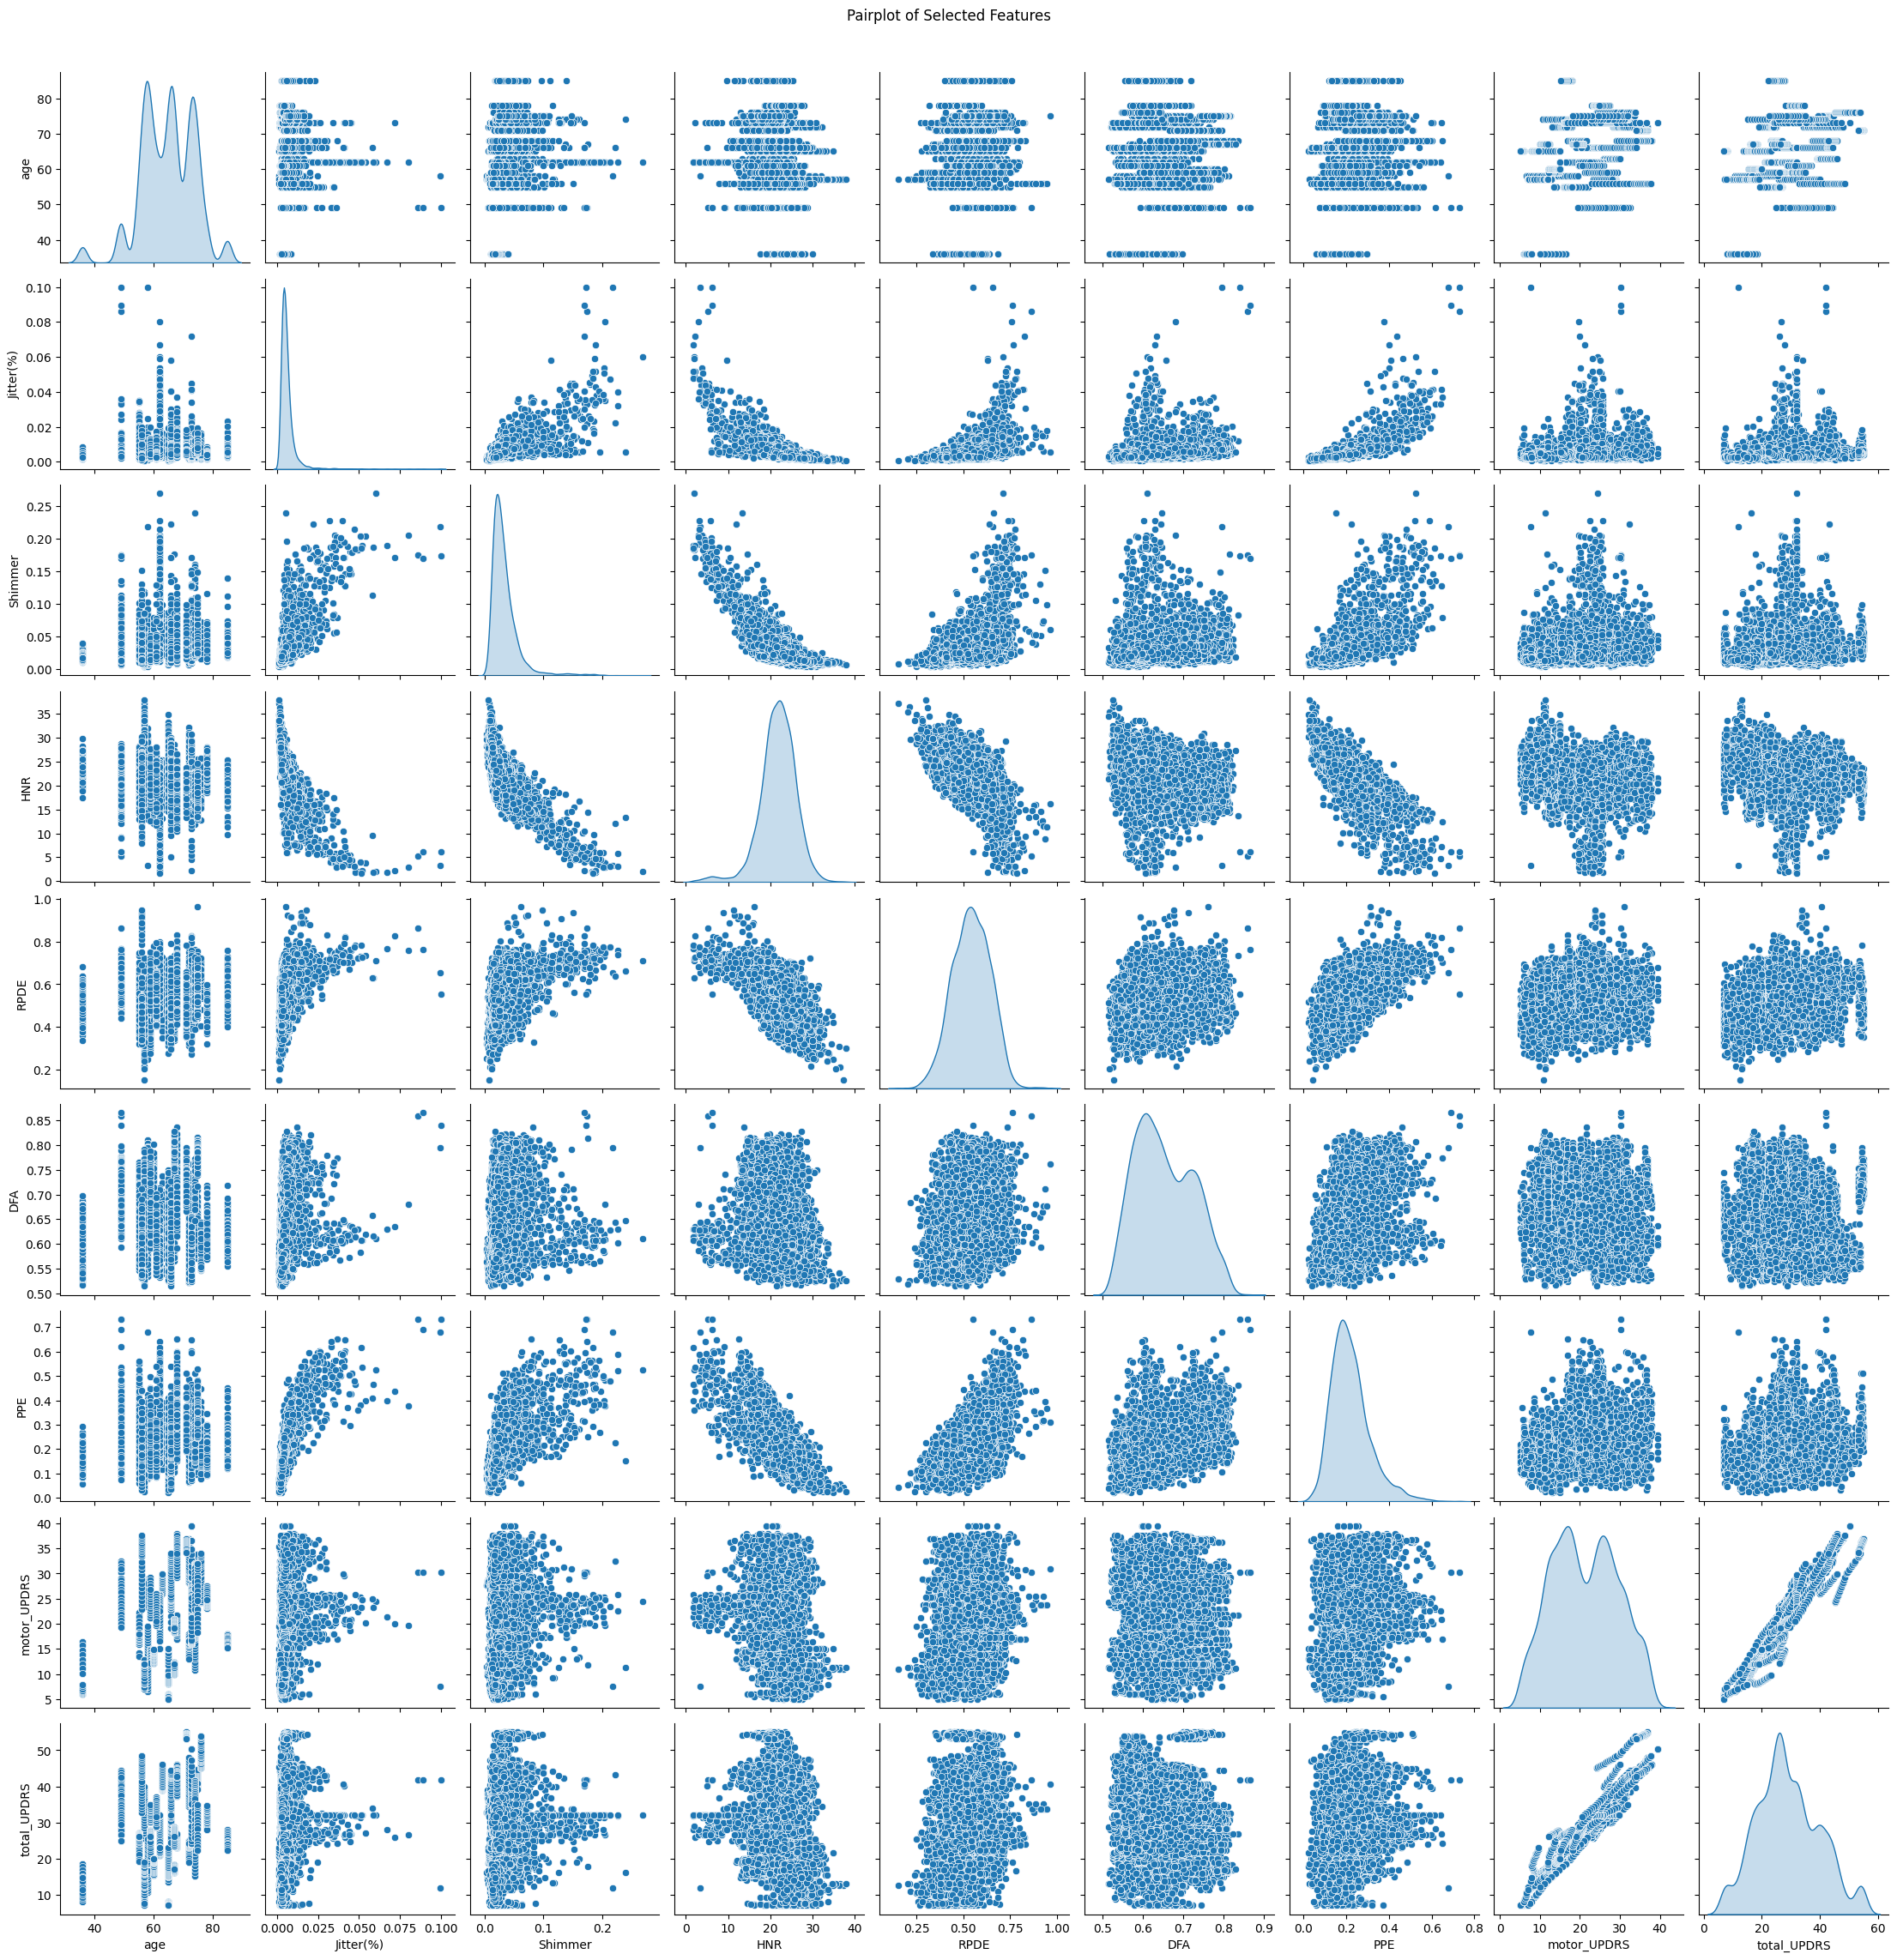

In [ ]:
# Figure 5: Pairplot of a subset of features
# Select a subset of features to plot
features_to_plot = ['age', 'Jitter(%)', 'Shimmer', 'HNR', 'RPDE', 'DFA', 'PPE', 'motor_UPDRS', 'total_UPDRS']
sns.pairplot(df[features_to_plot], diag_kind='kde')
plt.suptitle('Pairplot of Selected Features', y=1.02) 
plt.show()

# Feature Engineering

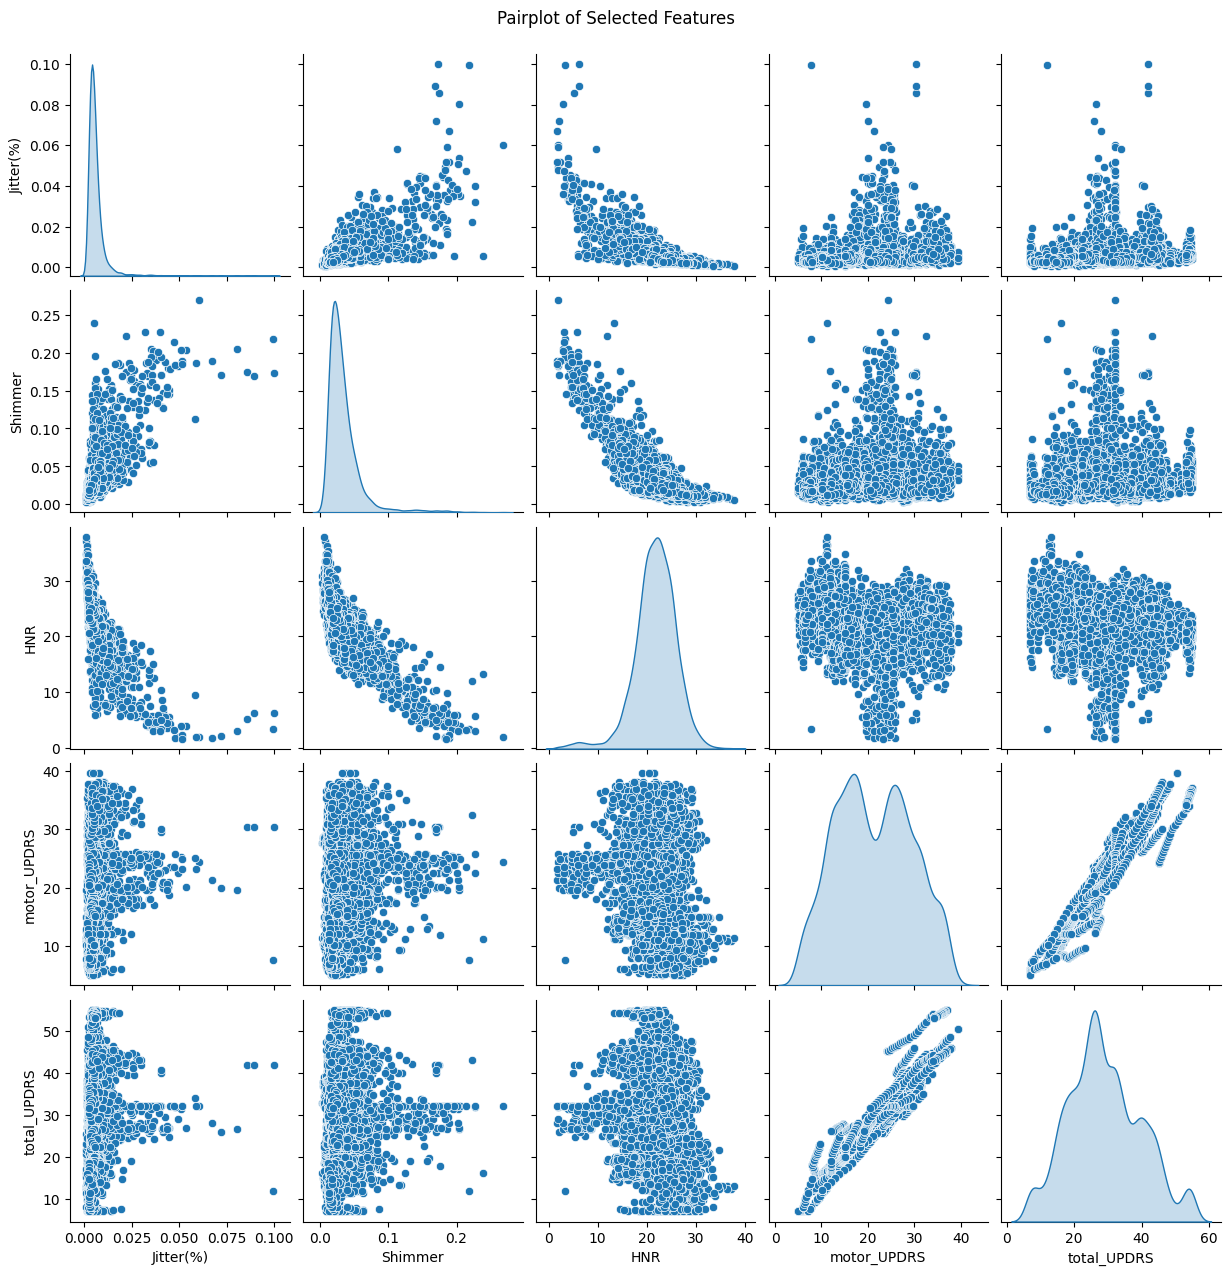

In [ ]:
# Part 3: Data Cleaning And Preprocessing:
"""
Since there are no missing values in this dataset, imputing is unnecessary.
I understand there are marks for this section, so instead of just cleaning, I'll
perform some feature engineering, to do this let's examine the pairplots. We notice
some interesting relationsips, and one of the more subtle, but important one's is the way in which
features like HNR, Shimmer, and Jitter either spike or drop on the midway point of the UPDRS scores.

These variables also boast some very interesting non-linear relationships between themselves, like for
the HNR and Shimmer distributions, which looks logarithmic:
"""

features_to_plot = ['Jitter(%)', 'Shimmer', 'HNR', 'motor_UPDRS', 'total_UPDRS']
sns.pairplot(df[features_to_plot], diag_kind='kde')
plt.suptitle('Pairplot of Selected Features', y=1.02) 
plt.show()

In [5]:
"""
Here's what I want to do. In order to encode some meaning in when the shimmer
or jitter is above a certain value, I'll create a binary indicator at some observed cutoff.
I'll make another indicator for HNR, but in that case it will only activate for the sample
if it's BELOW a certain value. This will hopefully help the model recognize some of the more
"""

# Create ordinal categories for 'Jitter(%)'
conditions_jitter = [
    (X['Jitter(%)'] < 0.015),
    (X['Jitter(%)'] >= 0.015) & (X['Jitter(%)'] < 0.03),
    (X['Jitter(%)'] >= 0.03)
]
choices_jitter = [0, 1, 2]  # Numerical encoding
X['jitter_category'] = np.select(conditions_jitter, choices_jitter, default=np.nan)

# Create binary categories for 'Shimmer'
X['shimmer_category'] = np.where(X['Shimmer'] < 0.09, 0, 1)

# Create binary categories for 'HNR'
X['hnr_category'] = np.where(X['HNR'] < 10, 0, 1)


/tmp/ipykernel_4377/3482240538.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['jitter_category'] = np.select(conditions_jitter, choices_jitter, default=np.nan)
/tmp/ipykernel_4377/3482240538.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['shimmer_category'] = np.where(X['Shimmer'] < 0.09, 0, 1)


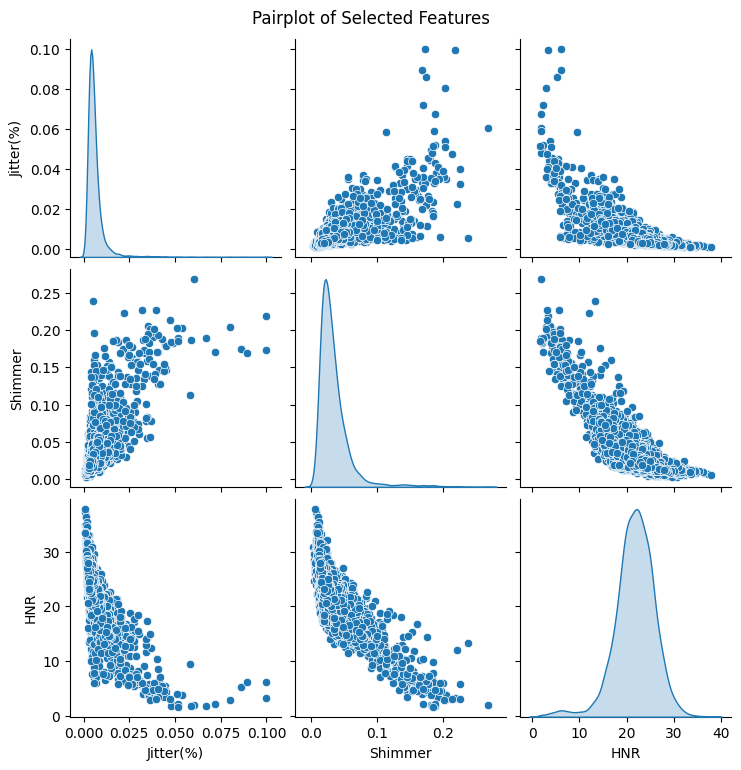

In [ ]:
features_to_plot = ['Jitter(%)', 'Shimmer', 'HNR']
sns.pairplot(df[features_to_plot], diag_kind='kde')
plt.suptitle('Pairplot of Selected Features', y=1.02) 
plt.show()

In [6]:
X['Jitter_log'] = np.log(X['Jitter(%)'])
X['Shimmer_log'] = np.log(X['Shimmer'])
X['NHR_log'] = np.log(X['NHR'])

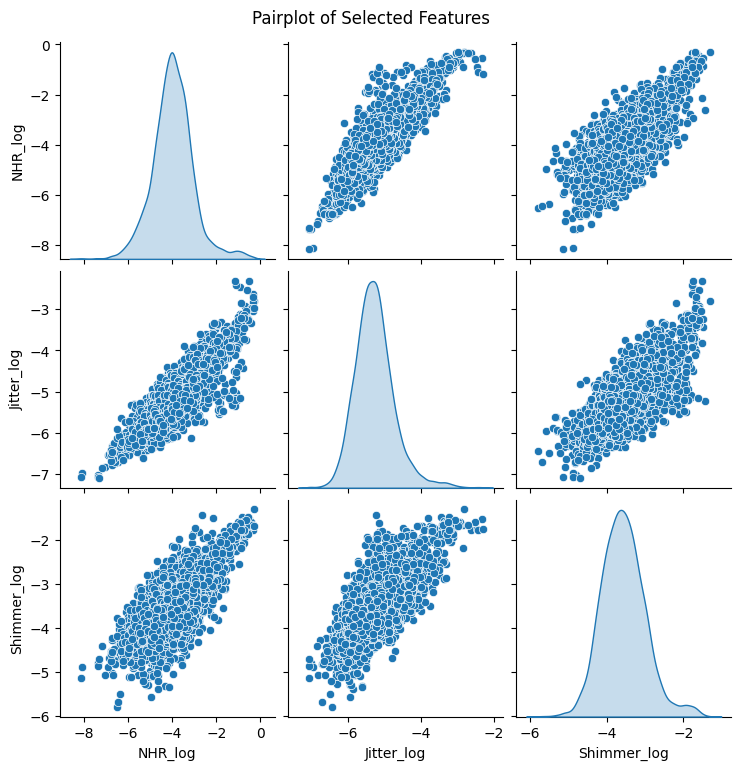

In [ ]:
features_to_plot = ['NHR_log', 'Jitter_log', 'Shimmer_log']
sns.pairplot(X[features_to_plot], diag_kind='kde')
plt.suptitle('Pairplot of Selected Features', y=1.02) 
plt.show()

In [7]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the entire dataset
scaler.fit(X)

# Transform the data
X_scaled = scaler.transform(X)

# Convert the scaled array back to a DataFrame for easier handling in pandas
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [8]:
from sklearn.model_selection import GroupShuffleSplit

# URL of the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/telemonitoring/parkinsons_updrs.data"

# Import the dataset
data = pd.read_csv(url)
patient_ids = data.iloc[:,0]

full_data = pd.concat([patient_ids, X_scaled, y], axis=1)

# Initialize GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
for train_idx, test_idx in gss.split(full_data, groups=patient_ids):
    train_data = full_data.iloc[train_idx]
    test_data = full_data.iloc[test_idx]

# Now split the train_data further into training and validation sets
gss_val = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_idx, val_idx in gss_val.split(train_data, groups=train_data.iloc[:, 0]):
    train_data_final = train_data.iloc[train_idx]
    val_data_final = train_data.iloc[val_idx]

# Drop the patient identifier column for modeling
train_data_final = train_data_final.drop(columns=train_data_final.columns[0])
val_data_final = val_data_final.drop(columns=val_data_final.columns[0])
test_data_final = test_data.drop(columns=test_data.columns[0])

# Splitting the final train, validation, and test sets into features and targets
X_train, y_train = train_data_final.iloc[:, :-2], train_data_final.iloc[:, -2]
X_val, y_val = val_data_final.iloc[:, :-2], val_data_final.iloc[:, -2]
X_test, y_test = test_data_final.iloc[:, :-2], test_data_final.iloc[:, -2]

In [8]:
print(f"Number of Training Samples: {y_train.shape[0]}")
print(f"Number of Validation Samples: {y_val.shape[0]}")
print(f"Number of Test Samples: {y_test.shape[0]}")

Number of Training Samples: 4069
Number of Validation Samples: 571
Number of Test Samples: 1235


# Modelling


In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
# Train the Random Forest Regressor
rf_regressor.fit(X_train, y_train)
# Predict on the test set
rf_predictions = rf_regressor.predict(X_val)
# Evaluate the Random Forest Regressor
rf_mse = np.sqrt(mean_squared_error(y_val, rf_predictions))
rf_r2 = r2_score(y_val, rf_predictions)
print(f"Random Forest Regressor Root Mean Squared Error: {rf_mse}")
print(f"Random Forest Regressor R^2 Score: {rf_r2}")

Random Forest Regressor Root Mean Squared Error: 13.106225327156556
Random Forest Regressor R^2 Score: -0.4420494498277785


In [13]:
from sklearn.linear_model import LinearRegression
# Initialize the Linear Regression model
linear_regressor = LinearRegression()

# Fit the model on the training data
linear_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = linear_regressor.predict(X_val)

# Calculate the performance metrics
mse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

# Print the metrics
print(f'Linear Regression Root Mean Squared Error: {mse}')
print(f'Linear Regression R^2 Score: {r2}')

Linear Regression Root Mean Squared Error: 11.588709485793238
Linear Regression R^2 Score: -0.12744416758685984


In [ ]:
%pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 3.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [15]:
from xgboost import XGBRegressor

# Initialize the XGBoost Regressor
xgb_regressor = XGBRegressor(n_estimators=100, random_state=42)
# Train the XGBoost Regressor
xgb_regressor.fit(X_train, y_train)
# Predict on the test set
xgb_predictions = xgb_regressor.predict(X_val)
# Evaluate the XGBoost Regressor
xgb_mse = np.sqrt(mean_squared_error(y_val, xgb_predictions))
xgb_r2 = r2_score(y_val, xgb_predictions)
print(f"XGBoost Regressor Root Mean Squared Error: {xgb_mse}")
print(f"XGBoost Regressor R^2 Score: {xgb_r2}")

XGBoost Regressor Root Mean Squared Error: 13.19102710842828
XGBoost Regressor R^2 Score: -0.46077093260800983


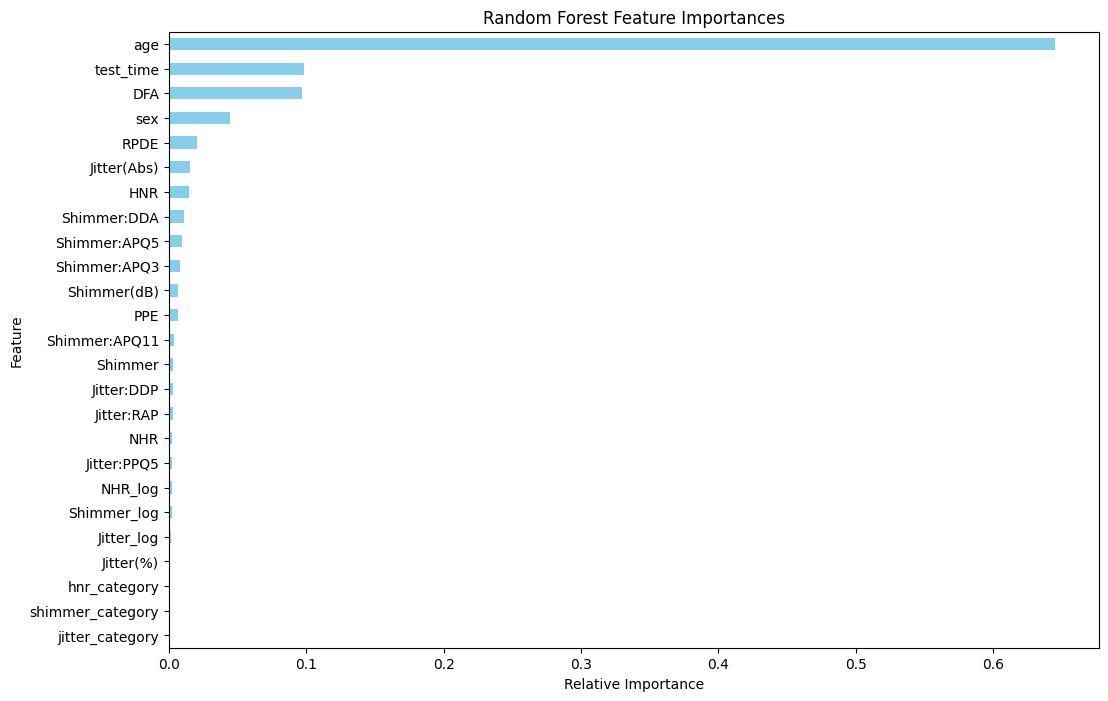

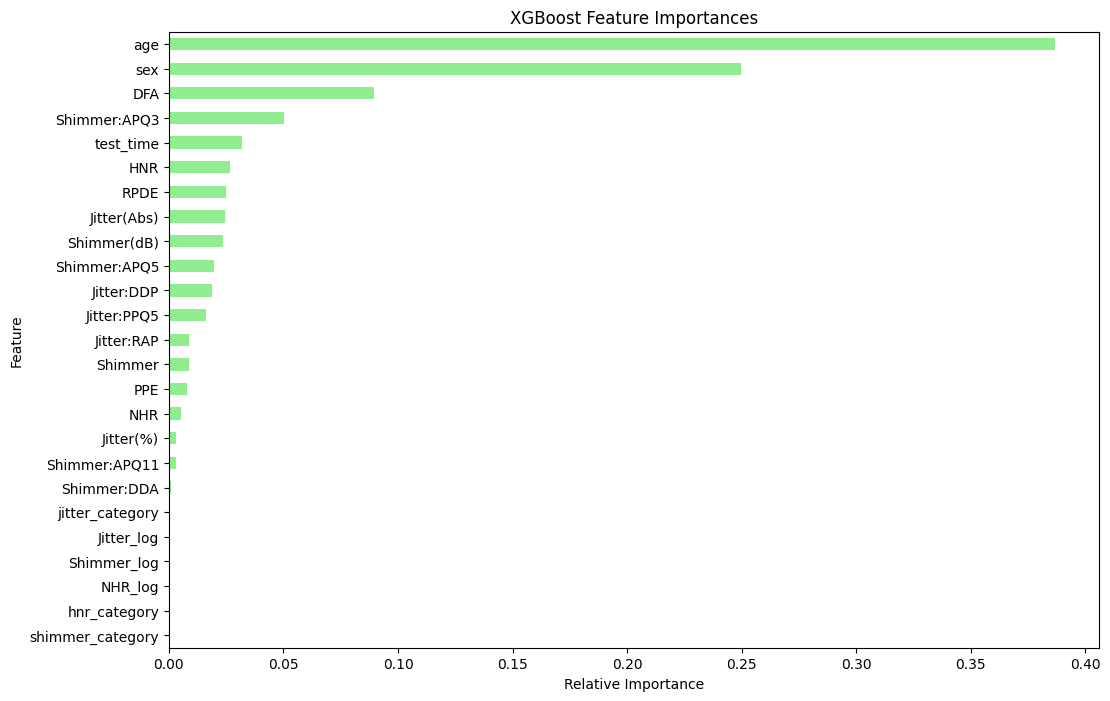

In [17]:

# Get feature importances from the models
rf_importances = rf_regressor.feature_importances_
xgb_importances = xgb_regressor.feature_importances_

# Create a pandas Series for easier plotting
rf_importances_series = pd.Series(rf_importances, index=X.columns)
xgb_importances_series = pd.Series(xgb_importances, index=X.columns)

# Sort the feature importances for better visualization
rf_importances_sorted = rf_importances_series.sort_values()
xgb_importances_sorted = xgb_importances_series.sort_values()

# Plot the Random Forest feature importances
plt.figure(figsize=(12, 8))
rf_importances_sorted.plot(kind='barh', color='skyblue')
plt.title('Random Forest Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.show()

# Plot the XGBoost feature importances
plt.figure(figsize=(12, 8))
xgb_importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('XGBoost Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.show()